Code adopted from user huynhe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

In [2]:
user_engagement = pd.read_csv('C:\\Users\\rxbro\\Documents\\1481069814_relax_challenge\\relax_challenge\\takehome_user_engagement.csv')
users = pd.read_csv('C:\\Users\\rxbro\\Documents\\1481069814_relax_challenge\\relax_challenge\\takehome_users.csv', encoding='latin-1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<p>To begin, I'll start by creating the target column adopted_user.  This is defined as any user that has logged into the product on three separate days within a 7 day period. </p>
<p>I will need to resample the data by changing the time stamp and add a column for each a login occurred.  This is necessary because users can login multiple times on the same day.  After that, we can resample that to weekly and sum the total daily logins.</p>
<p>The purpose of the user engagements dataframe is to define a column of user id's that are adopted users.  The time stamp information can be scrapped because is extraneous</p>

In [5]:
user_engagement['time_stamp'].head()

0    2014-04-22 03:53:30
1    2013-11-15 03:45:04
2    2013-11-29 03:45:04
3    2013-12-09 03:45:04
4    2013-12-25 03:45:04
Name: time_stamp, dtype: object

In [6]:
# Convert time_stamp column to dtype datetime
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

In [7]:
# Resample data
daily_users = user_engagement.groupby('user_id').resample('1D', on='time_stamp').sum().drop('user_id', axis=1)

In [8]:
# Reset indicies
daily_users.reset_index(inplace=True)

In [9]:
# Remove all invalid entries that were made during resampling
daily_users = daily_users[daily_users['visited'] != 0]
daily_users['daily_visits'] = 1

In [10]:
# Resample data to weekly
weekly_users = daily_users.groupby('user_id').resample('1W', on='time_stamp').sum().drop('user_id', axis=1)

In [11]:
weekly_users = weekly_users[weekly_users['visited'] != 0]

In [12]:
weekly_users['adopted_user'] = weekly_users['daily_visits'].apply(lambda x: 1 if x >= 3 else 0)

In [13]:
# Verify if visited and daily vists columns are equivalent to each other.
weekly_users['visited'].equals(weekly_users['daily_visits'])

True

In [14]:
weekly_users.head()

visited  daily_visits  adopted_user
user_id time_stamp                                     
1       2014-04-27        1             1             0
2       2013-11-17        1             1             0
        2013-12-01        1             1             0
        2013-12-15        1             1             0
        2013-12-29        1             1             0

Now we need to group the user ids together.  This will be done by taking the sum of the remaining columns and change the adopted user column to a binary variable.

In [15]:
# Reset index
weekly_users.reset_index(inplace=True)
# Group data and take the sum of daily visits and adopted user.
grouped_users = weekly_users.groupby('user_id').agg({'daily_visits':'sum', 'adopted_user': 'sum'}).reset_index()

In [16]:
grouped_users['adopted_user'] = grouped_users['adopted_user'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
grouped_users.head()

,user_id,daily_visits,adopted_user
0,1,1,0
1,2,14,1
2,3,1,0
3,4,1,0
4,5,1,0


In [18]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [19]:
# Time for sanity check...make sure no user ids were lost
assert grouped_users['user_id'].nunique() == user_engagement['user_id'].nunique()

In [20]:
print(users['object_id'].nunique())
print(grouped_users['user_id'].nunique())

12000
8823


<p>Since the users dataset has more unique user ids than the user engagement dataset, I will do a left merge to retain all the rows in the main dataset.  After that, the null values from the merge will be replaced with 0's to represent that the user has no login activity.</p>
<p>The last_session_creation_time column will be converted from a UNIX timestamp to a more readable format.  The creation_time column will be converted to a datetime object.</p>

In [21]:
# Convert last_session_creation_time to datetime object.
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
# Convert creation_time to datetime object.
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [22]:
# Merge data
merged_users = users.merge(grouped_users, how='left', left_on='object_id', right_on='user_id')
# Drop user_id column
merged_users.drop('user_id', axis=1, inplace=True)

In [23]:
# Look at merged dataframe for nulls
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  daily_visits                8823 non-null   float64       
 11  adopted_user                8823 non-null   float64   

It seems that there are two columns not taken into account; last_session_creation_time and invited_by_user_id.  These are not from the user engagements dataframe, so filling the null values is not a good idea.  Let's explore the nulls first.

In [25]:
merged_users[merged_users['last_session_creation_time'].isnull()].head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0,NaN,NaN
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,NaN,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,NaN,NaN
17,18,2013-08-24 00:26:46,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,NaT,0,0,2,3153.0,NaN,NaN
25,26,2013-07-28 00:53:32,Wexler Florian,FlorianWexler@jourrapide.com,ORG_INVITE,NaT,0,0,56,11857.0,NaN,NaN
31,32,2013-04-17 16:21:30,Perez Timothy,TimothyJPerez@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,98,NaN,NaN,NaN
33,34,2014-02-03 20:55:18,Holm Sara,SaraMHolm@hotmail.com,ORG_INVITE,NaT,0,0,33,3721.0,NaN,NaN
34,35,2013-08-01 10:55:26,Krueger Dieter,DieterKrueger@gustr.com,PERSONAL_PROJECTS,NaT,0,0,59,NaN,NaN,NaN


In [27]:
merged_users[merged_users['invited_by_user_id'].isnull()].head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,NaN
10,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,2013-12-27 03:55:54,0,0,69,NaN,1.0,0.0
13,14,2012-10-11 16:14:33,Rivera Bret,BretKRivera@gmail.com,SIGNUP,2012-10-12 16:14:33,0,0,0,NaN,1.0,0.0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,NaN,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,NaN,NaN
18,19,2013-05-24 14:56:36,Collins Arlene,ArleneRCollins@gmail.com,SIGNUP,2013-05-30 14:56:36,1,0,0,NaN,2.0,0.0
19,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 11:46:38,0,0,58,NaN,7.0,1.0
20,21,2013-01-22 12:27:42,Hunter Alfie,AlfieHunter@gmail.com,PERSONAL_PROJECTS,2013-01-22 12:27:42,0,0,54,NaN,1.0,0.0


In [28]:
merged_users['invited_by_user_id'].describe()

count     6417.000000
mean      5962.957145
std       3383.761968
min          3.000000
25%       3058.000000
50%       5954.000000
75%       8817.000000
max      11999.000000
Name: invited_by_user_id, dtype: float64

The last_session_creation_time column indicates when the user last logged in; if the user never logged in at all, then this value would be null.  This makes sense as there is an equal number of null values in this variable to the nulls from the merge.  This column will be filled with their creation times.
<br />
The null values in the invited_by_user_id are represented by internal invitations.  The nulls in this column will be changed to zeroes.

In [29]:
merged_users['last_session_creation_time'].fillna(merged_users['creation_time'], inplace=True)
merged_users['invited_by_user_id'].fillna(0, inplace=True)

In [31]:
merged_users['daily_visits'].fillna(0, inplace=True)
merged_users['adopted_user'].fillna(0, inplace=True)

In [32]:
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  daily_visits                12000 non-null  float64       
 11  adopted_user                12000 non-null  float64   

The invited_by_user_id and adopted_user should be int64.  Let's change them.

In [33]:
merged_users['invited_by_user_id'] = merged_users['invited_by_user_id'].astype('int')
merged_users['adopted_user'] = merged_users['adopted_user'].astype('int')

Now we can do some EDA on the binary and numerical columns.

In [34]:
binary = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']
numerical = 'daily_visits'
binary.append(numerical)

In [35]:
target = merged_users[merged_users['adopted_user'] == 1]
not_target = merged_users[merged_users['adopted_user'] == 0]

(array([1.1166e+04, 2.6100e+02, 1.6300e+02, 1.1200e+02, 9.2000e+01,
        8.0000e+01, 5.3000e+01, 4.2000e+01, 2.2000e+01, 9.0000e+00]),
 array([  0. ,  60.6, 121.2, 181.8, 242.4, 303. , 363.6, 424.2, 484.8,
        545.4, 606. ]),
 <BarContainer object of 10 artists>)

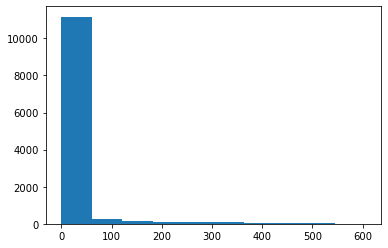

In [37]:
plt.hist(merged_users[numerical])

In [38]:
print(len(target), len(not_target))

1445 10555


The plot is skewed strongly to the right.  I'll scale this down with StandardScaler later...the dataset is also very unbalanced (12% target vs 88% not_target).

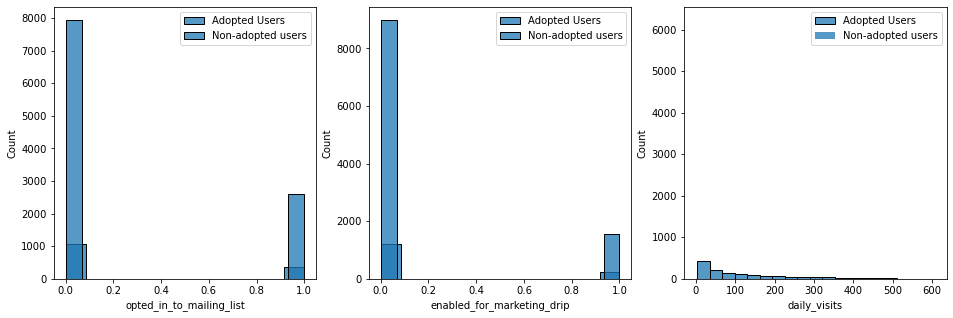

In [41]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
for i in range(3):
    sns.histplot(target[binary[i]], ax=ax[i], label='Adopted Users').legend()
    sns.histplot(not_target[binary[i]], ax=ax[i], label='Non-adopted users', kde=False).legend()

In [42]:
merged_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1.0,0


In [43]:
# Create a column for creation_to_active
merged_users['creation_to_active'] = (merged_users['last_session_creation_time'] - merged_users['creation_time']).dt.days + 1
# Create a column for login_perc
merged_users['login_perc'] = merged_users['daily_visits'] / merged_users['creation_to_active']

In [44]:
# Create a column for e-mail domain.
merged_users['email_domain'] = merged_users['email'].apply(lambda x: x.split('@')[-1])

In [45]:
merged_users[merged_users['creation_to_active'] == 1].shape

(6204, 15)

In [46]:
merged_users['email_domain'].nunique()

1184

Some columns need to be dropped here because they are redundant. <br />
Name: unnecessary as object_id is the unique identifier. <br />
E-mail: same as name; we extracted the domain of the email address. <br/>
creation_time and last_session_creation_time: These two columns don't show in our model because we don't know the start and end dates of the information being gathered.

In [47]:
# Drop unnecessary columns.
merged_users.drop(['creation_time', 'name', 'email', 'last_session_creation_time'], axis=1, inplace=True)

In [48]:
# Split the dataframe into target and not_target
target = merged_users[merged_users['adopted_user'] == 1]
not_target = merged_users[merged_users['adopted_user'] == 0]

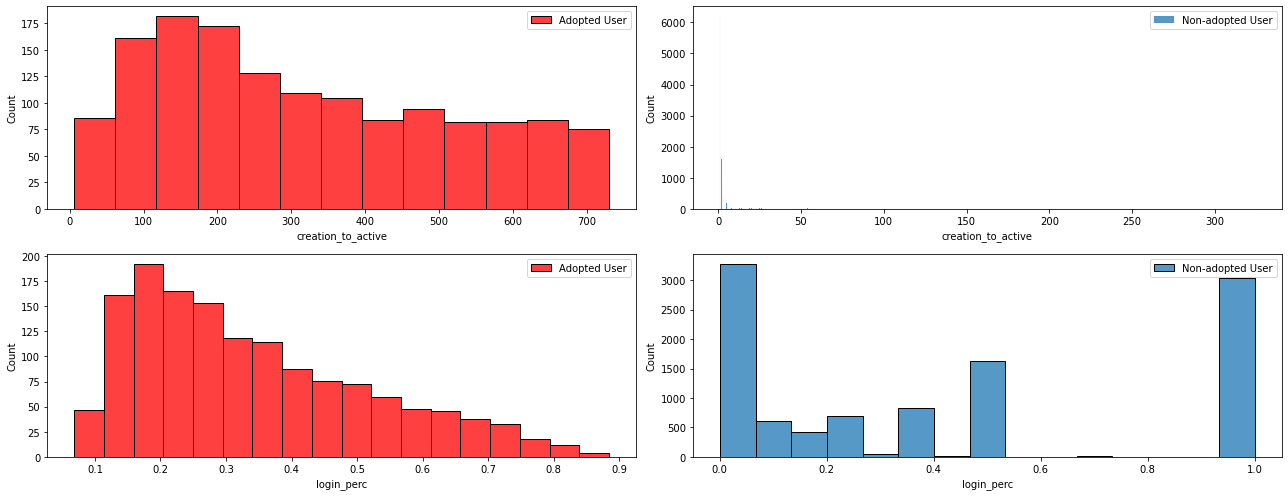

In [49]:
new_features = ['creation_to_active', 'login_perc']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,7))
for i in range(2):
    sns.histplot(target[new_features[i]], ax=ax[i][0], color='r', label='Adopted User', kde=False).legend()
    sns.histplot(not_target[new_features[i]], ax=ax[i][1], label='Non-adopted User', kde=False).legend()
plt.tight_layout()

Now we go to feature importance with random forest.  We need to do some preprocessing with pd.get_dummies and StandardScaler.

In [50]:
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   org_id                      12000 non-null  int64  
 5   invited_by_user_id          12000 non-null  int32  
 6   daily_visits                12000 non-null  float64
 7   adopted_user                12000 non-null  int32  
 8   creation_to_active          12000 non-null  int64  
 9   login_perc                  12000 non-null  float64
 10  email_domain                12000 non-null  object 
dtypes: float64(2), int32(2), int64(5), object(2)
memory usage: 1.0+ MB


In [51]:
X = merged_users.drop(['object_id', 'adopted_user'], axis=1)
y = merged_users['adopted_user']

In [52]:
numerical = ['daily_visits', 'creation_to_active', 'login_perc']
categorical = [col for col in merged_users.columns if col not in numerical]
categorical.remove('object_id')
categorical.remove('adopted_user')

In [53]:
numerical_data = StandardScaler().fit_transform(X[numerical])
numerical_df = pd.DataFrame(numerical_data, columns=numerical)
categorical_df = X[categorical].copy()
for col in categorical:
    categorical_dummies = pd.get_dummies(categorical_df[col]).rename(columns=lambda x: col+str(x))
    categorical_df = categorical_df.join(categorical_dummies)
    del categorical_df[col]

In [54]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_visits        12000 non-null  float64
 1   creation_to_active  12000 non-null  float64
 2   login_perc          12000 non-null  float64
dtypes: float64(3)
memory usage: 281.4 KB


In [55]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Columns: 4175 entries, creation_sourceGUEST_INVITE to email_domainzwmry.com
dtypes: uint8(4175)
memory usage: 48.2 MB


In [56]:
# Merge the dataframes
merged_df = pd.concat([numerical_df, categorical_df], axis=1)

In [57]:
rf = RandomForestClassifier().fit(merged_df, y)

<AxesSubplot:xlabel='importance', ylabel='feature'>

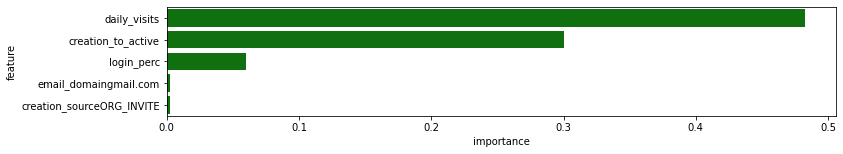

In [58]:
importances = rf.feature_importances_
features = pd.DataFrame({'feature':merged_df.columns, 'importance':importances})
features.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(12,2))
sns.barplot(x=features['importance'][:5], y=features['feature'][:5], color='green', orient='h')

In [59]:
X_train, X_test, y_train, y_test = train_test_split(merged_df, y, test_size=0.25)

In [60]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [61]:
predicted_train_values = rf.predict_proba(X_train)[:,-1]
predicted_test_values = rf.predict_proba(X_test)[:, -1]
print(roc_auc_score(y_test, predicted_test_values))

0.9960871763925956


<AxesSubplot:title={'center':'Testing data'}, xlabel='adopted_user', ylabel='Density'>

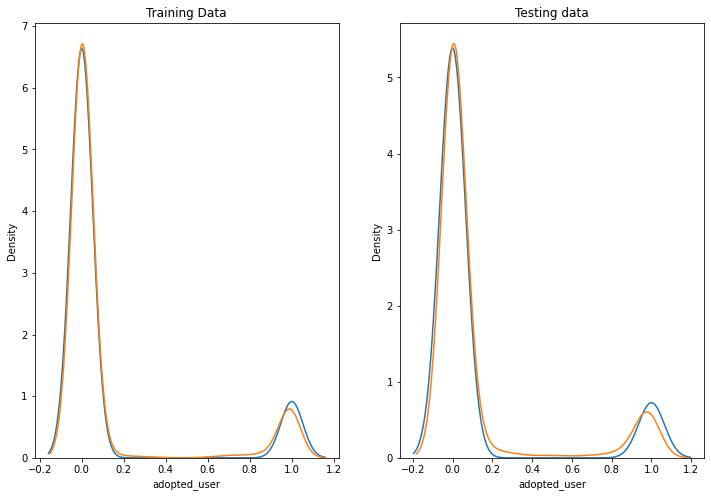

In [62]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')